# Problemática a resolver

Las sirenas endémicas que rodean la isla donde se encuentra tu celda tienen un seductor canto con el que atraen a sus machos y aseguran la persistencia de sus especie. Ha emigrado, solicitando refugio, una especie de sirenas de otros lares. Esta especie emite un sonido que interfiere con el canto de las sirenas endémicas. El guardián del océano va a delimitar una región para cada especie y pide tu ayuda para distribuirlas. Tú recibiste una base de datos (sirenas_endemicas_y_sirenas_migrantes_historico.csv) que el museo de historia natural te ha facilitado con características de individuos de cada especie. Recibiste también una base de datos con los individuos que el guardián va a clasificar (sirenas_endemicas_y_sirenas_migrantes.csv). Indica en esta última, a qué especie de sirena pertenece cada individuo.


Inicialmente se importan las librerias necesarias.

In [4]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Exploración de los datos

In [5]:
# Carga de datasets y revisión de dataset de entrenamiento
df = pd.read_csv("sirenas_endemicas_y_sirenas_migrantes_historico.csv", header=0)
to_classify = pd.read_csv("sirenas_endemicas_y_sirenas_migrantes.csv")
label=[]
[label.append(variable) for variable in df['especie']]
print("El dataset de entranamiento posee", len(df), "muestras, con", label.count('sirena_migrante'), "muestras por cada categoría, las categorías son:",label[0], "y", label[len(label)-1])
df.head(3)

El dataset de entranamiento posee 100 muestras, con 50 muestras por cada categoría, las categorías son: sirena_migrante y sirena_endemica


,v1,v2,v3,v4,especie
0,4.3,3.0,1.1,0.1,sirena_migrante
1,4.8,3.0,1.4,0.1,sirena_migrante
2,4.9,3.1,1.5,0.1,sirena_migrante


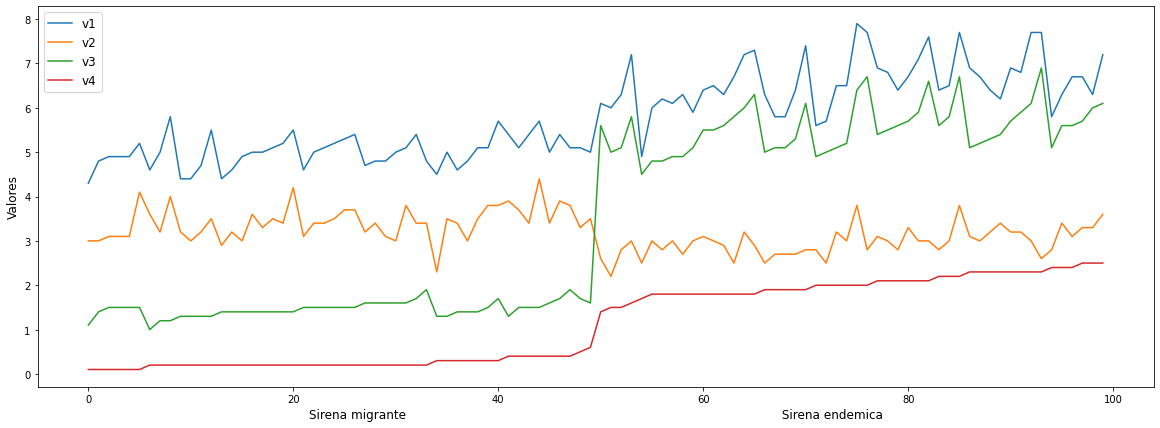

In [6]:
# Gráfica de datos de entrenamiento en bruto
def plot_raw_data(variables, x_label, y_label):
    plt.figure(figsize=(20,7), facecolor='w', edgecolor='k')
    for i in variables:
        plt.plot(df[i])
    plt.xlabel(x_label,fontsize=12)
    plt.ylabel(y_label,fontsize=12)
    plt.legend(variables,fontsize=12)
variables=['v1', 'v2', 'v3', 'v4']
plot_raw_data(variables, 'Sirena migrante                                                                                                 Sirena endemica', 'Valores')

In [7]:
y = df['especie']
df = df.drop("especie", axis=1)
df.head(3)

,v1,v2,v3,v4
0,4.3,3.0,1.1,0.1
1,4.8,3.0,1.4,0.1
2,4.9,3.1,1.5,0.1


In [8]:
to_classify = to_classify.drop("especie", axis=1)
to_classify.head(3)

,v1,v2,v3,v4
0,6.6,2.3,4.1,1.5
1,4.5,2.9,2.4,1.6
2,5.7,2.3,6.3,0.4


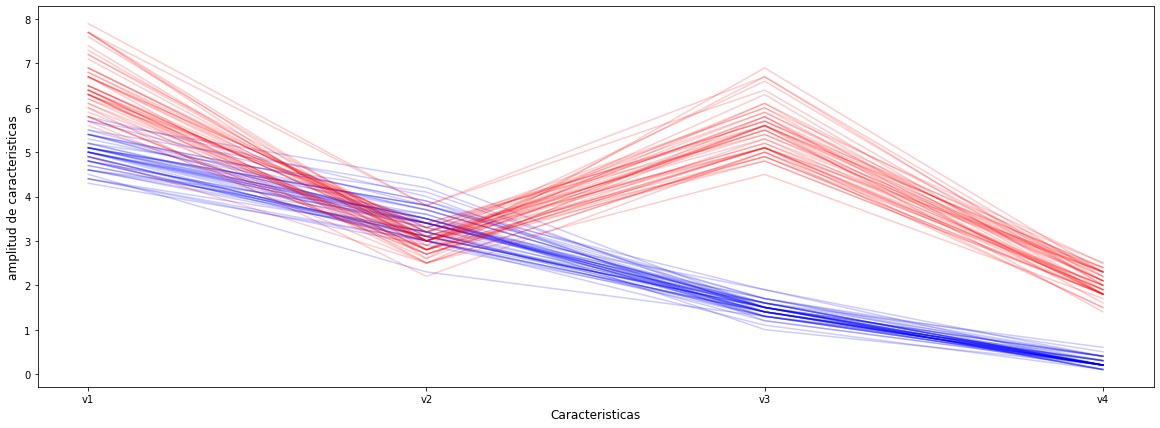

In [22]:
def plot_raw_data(variables, x_label, y_label, df, target, results, y_prediction):
    plt.figure(figsize=(20,7), facecolor='w', edgecolor='k')
    for i in range(0, len(df)-1):
        plt.plot(df.iloc[i],alpha=0.2, color='red') if i >=50 else plt.plot(df.iloc[i],alpha=0.2, color='blue')
        plt.xlabel(x_label,fontsize=12)
        plt.ylabel(y_label,fontsize=12)
    if results == True:
        for i in range(0, len(target)-1):
            plt.plot(target.iloc[i],alpha=0.5, color='red') if y_prediction[i]=='sirena_endemica' else plt.plot(target.iloc[i],alpha=0.5, color='blue')
plot_raw_data(variables, "Caracteristicas", "amplitud de caracteristicas", df, to_classify, False, False)

El dataset cuenta con las categorias organizadas en orden secuencial, por lo tanto los primeros 50 valores de las variables corresponden a la primer categoría, correspondiente a la de sirena migrante como se observa en la figura y los ultimos 50 corresponden a la categoría de sirena endemica.

A partir de estos datos se infiere que las variables v3 y v4 tienen un cambio considerable y notorio al tratarse de uno u otro tipo de sirena, por otro lado, el caso del v1 y v2 contienen un pequeño cambio en la tendencia pero no es muy claro o significativo para realizar una distinción de clases.

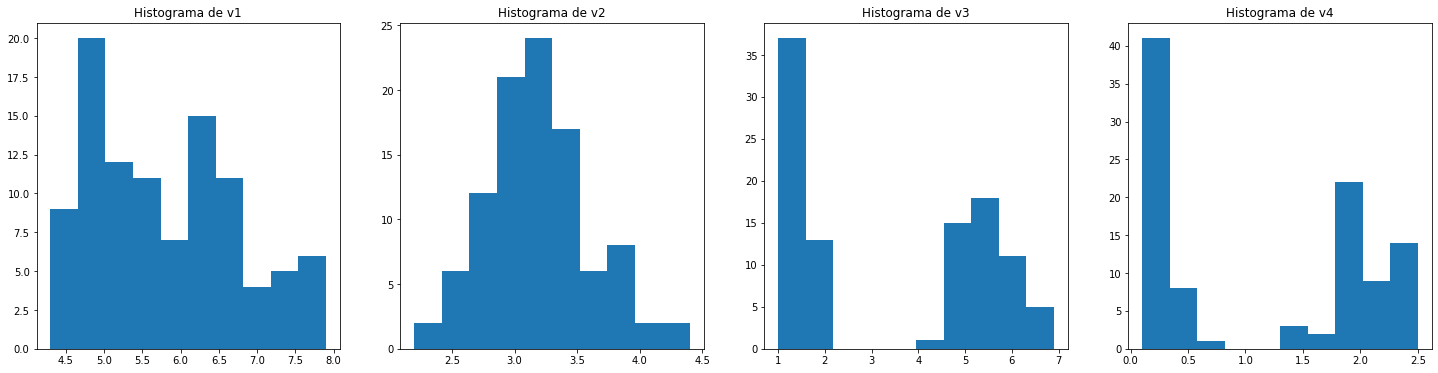

In [11]:
# histogramas de cada variable de entrenamiento, incluyendo labels
def plot_hist():
    raw_data = ['v1', 'v2', 'v3', 'v4']
    fig, axs = plt.subplots(1,4,figsize=(25,6))
    c=0
    for var in raw_data:
        axs[c].hist(df[var])
        axs[c].set_title("Histograma de " + var) 
        c+=1
    plt.show()
plot_hist()

Los histogramas confirman que las variables que tienen un cambio más signiticativo entre una especie de sirena u otro es el v3 y v4, donde existe un espacio claro entre un grupo de datos y otro, lo cual ayudará mucho a que un modelo de aprendizaje logre una distinción clara entre las clases. Se confirma además que no existe una clara distincion entre una categoria y otra por medio de las variables v1 y v2.

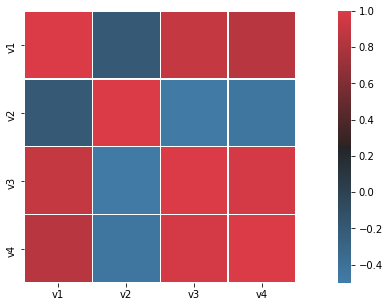

In [14]:
# Analizando correlación de los datos
def generate_correlation_heatmap():
    corr = df.iloc[:,:].corr(method="pearson")
    cmap = sns.diverging_palette(240, 10, n=9, center="dark", as_cmap=True)
    sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, Linewidths=.2)
    plt.rcParams['figure.figsize']=(12,5)
generate_correlation_heatmap()

Se observa que la variable v2 presenta baja correlación con las otras 3 variables, esto posiblemente genere conflictos a la hora de entrenar el modelo.

# Creación de modelo de clasificación

In [26]:
# definición de modelo SVC
def train_modelo_SVC(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=50)
    scaler = StandardScaler().fit(x_train)
    svc_model = SVC()
    svc_model.fit(x_train, y_train)
    SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, probability=False, random_state=None,
      shrinking=True, tol=0.001, verbose=False)
    y_predict = svc_model.predict(x_test)
    # print(classification_report(y_test, y_predict))
    return svc_model

# entrenamiento con las 4 variables como entrada al modelo
variables=['v1', 'v2', 'v3', 'v4']
x = df[variables]
svc_model_all_variables = train_modelo_SVC(x, y)
x_validation = to_classify[variables]
y_prediction_all = svc_model_all_variables.predict(x_validation)
print(y_prediction_all)

# entrenamiento con v3 y v4 como entrada al modelo
variables=['v3', 'v4']
x = df[variables]
svc_model = train_modelo_SVC(x, y)
x_validation = to_classify[variables]
y_prediction_2 = svc_model.predict(x_validation)
print(y_prediction_2)
# for pred in range(0,len(y_prediction_all)-1):
#     if y_prediction_all[pred] !=  y_prediction[pred]:
#         print("sjdd")


# entrenamiento con v2 v3 y v4 como entrada al modelo
variables=['v1','v3', 'v4']
x = df[variables]
svc_model = train_modelo_SVC(x, y)
x_validation = to_classify[variables]
y_prediction_3 = svc_model.predict(x_validation)
print(y_prediction_3)
# for pred in range(0,len(y_prediction_all)-1):
#     if y_prediction_all[pred] !=  y_prediction[pred]:
#         print("sjdd")

['sirena_endemica' 'sirena_migrante' 'sirena_endemica' 'sirena_migrante'
 'sirena_migrante' 'sirena_migrante' 'sirena_endemica' 'sirena_migrante'
 'sirena_endemica' 'sirena_migrante' 'sirena_endemica' 'sirena_migrante'
 'sirena_endemica' 'sirena_endemica' 'sirena_endemica' 'sirena_endemica'
 'sirena_migrante' 'sirena_endemica' 'sirena_endemica' 'sirena_migrante'
 'sirena_endemica' 'sirena_endemica' 'sirena_endemica' 'sirena_endemica'
 'sirena_endemica' 'sirena_migrante' 'sirena_endemica' 'sirena_endemica'
 'sirena_endemica' 'sirena_migrante' 'sirena_endemica' 'sirena_migrante'
 'sirena_endemica' 'sirena_endemica' 'sirena_endemica' 'sirena_migrante'
 'sirena_endemica' 'sirena_migrante' 'sirena_migrante']
['sirena_endemica' 'sirena_migrante' 'sirena_endemica' 'sirena_migrante'
 'sirena_migrante' 'sirena_migrante' 'sirena_endemica' 'sirena_migrante'
 'sirena_endemica' 'sirena_migrante' 'sirena_endemica' 'sirena_migrante'
 'sirena_endemica' 'sirena_endemica' 'sirena_endemica' 'sirena_endem

Clasificación realizada por modelo SVC entrenado con las cuatro variables


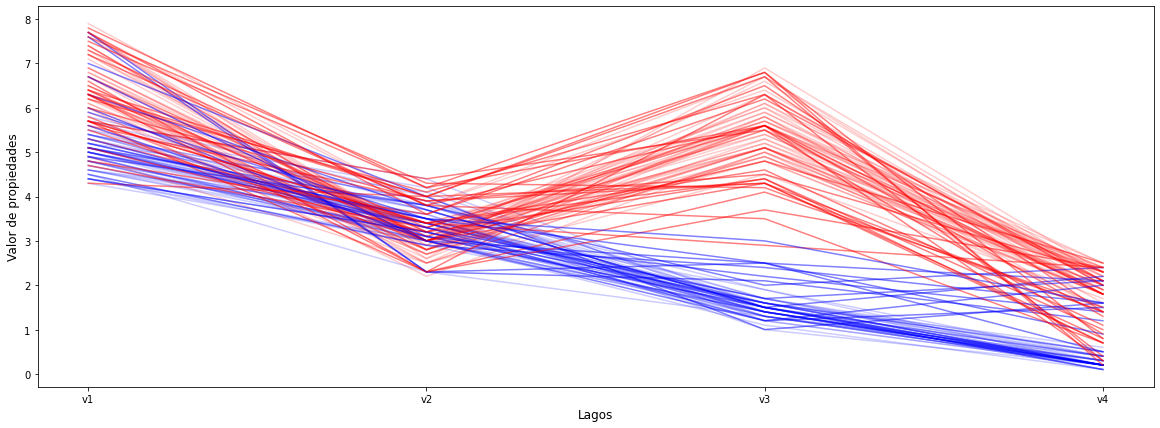

In [29]:
plot_raw_data(variables, "Lagos", "Valor de propiedades", df, to_classify, True,  y_prediction_all)
print("Clasificación realizada por modelo SVC entrenado con las cuatro variables")

Clasificación realizada por modelo SVC entrenado excluyendo v2


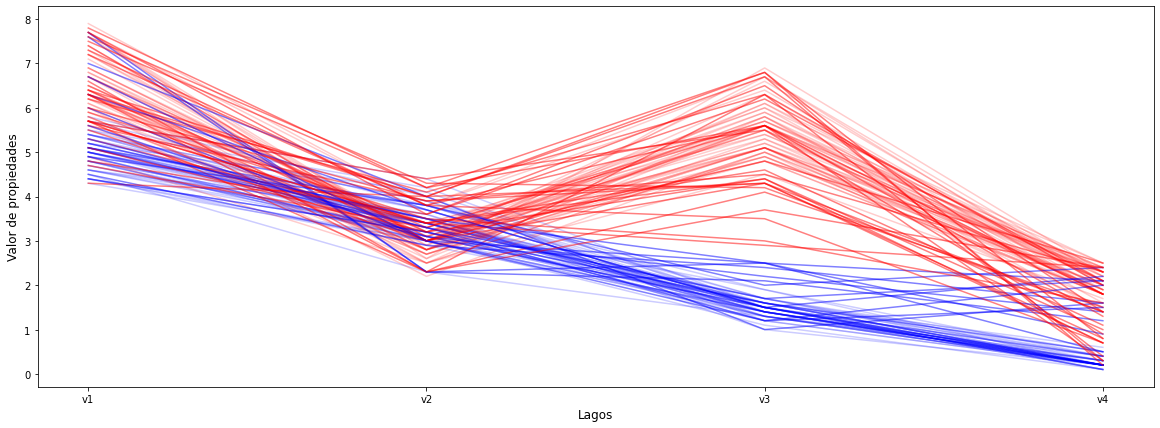

In [30]:
plot_raw_data(variables, "Lagos", "Valor de propiedades", df, to_classify, True,  y_prediction_3)
print("Clasificación realizada por modelo SVC entrenado excluyendo v2")

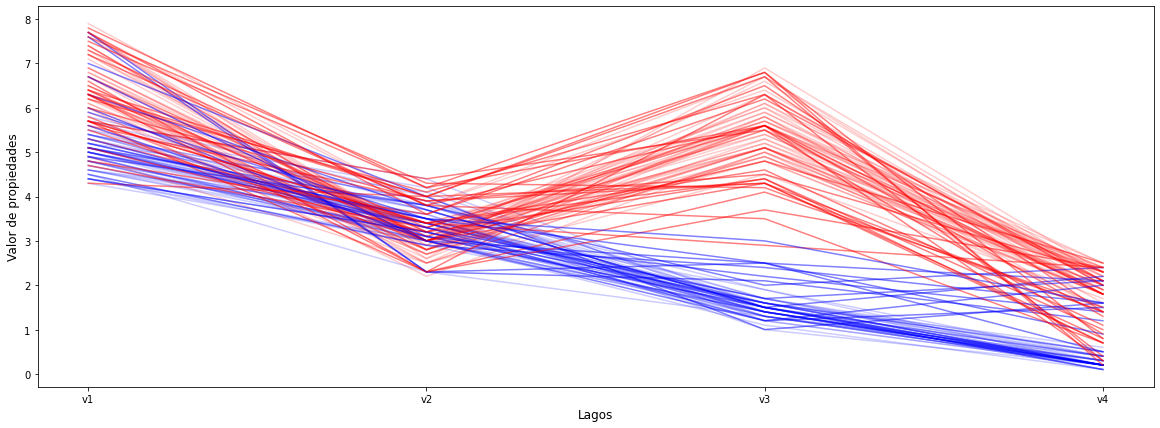

In [25]:
plot_raw_data(variables, "Lagos", "Valor de propiedades", df, to_classify, True,  y_prediction_2)
print("Clasificación realizada por modelo SVC entrenado excluyendo v1 y v2")

El mejor resultado se obtiene al excluir la variable v2, ya que no se obtienen distinciones mas claras entre las clases, en los otros dos casos existen (aunque pocas) predicciones de la clase equivocada